In [1]:
# usage: $python3 CULane_Remake.py [--no-vis]
# [--no-vis] for not showing frame, stopping after each frame

## Imports

In [2]:
from shutil import copy
from shutil import copyfile
import os
import sys
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from os import walk
import IPython
#IPython.embed() # to debug in notebook
import random
print("Successfully imported all")

Successfully imported all


## Convert notebook to python file

In [3]:
#!jupyter nbconvert --to script CULane_Remake.ipynb
# Can use the command line argument instead:
# jupyter nbconvert --to script CULane_Remake.ipynb

## Print pretty with colors

In [4]:
# Credit: https://stackoverflow.com/questions/287871/print-in-terminal-with-colors
class CMD_C:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'   # End formatting
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

## Helper functions

In [5]:
# Function of lane width varied over height
def lane_width_px(y):
    if y <= 260:
        return 1
    return (int) (y * 0.1 - 25)

In [6]:
def draw_lane(img, points, color):
    # Draw a line in for each point
    for i in range(points.shape[0]):
        point = points[i, :]
        lane_width = lane_width_px(point[1])
        cv2.line(img, (point[0] - lane_width // 2, point[1]), (point[0] + lane_width // 2, point[1]), color, 1) # Thickness = 1

In [7]:
def make_dir(dir_path):
    if (os.path.exists(dir_path)):
        print(dir_path, CMD_C.OKGREEN, " already exists in the current working direcrectory: ", CMD_C.ENDC, cwd, sep="")
    else:
        try:
            os.mkdir(dir_path)
        except OSError:
            print(FAIL, "Could not create destination folder: ", dir_path, ENDC)
            return False
        else:
            print("Sucessfully made destination folder: ", dir_path)
    return True

### Parse Command Args, other setup


In [8]:
display_results = False if sys.argv[-1] == "--no-vis" else True
print("Display results? = ", display_results)

Display results? =  True


In [9]:
cwd = os.getcwd()
print("CWD: ", cwd)

CWD:  /root/atlas_root/home/cjcramer/lane_lines/Scripts


In [10]:
# Folders of annotations
data_base_dir = "/root/atlas_root/teams/team-1/Datasets/CULane_Dataset/"
folders = ["laneseg_label_w16/"]      # Put all the annotation folder names here

folder_paths = [data_base_dir + folder for folder in folders]
dest_folder_extension = "_remake"
annotation_paths = []

## Create a destination folder for each folder in folders

In [11]:
for folder in folders:
    dest_folder_name = folder[:-1] + dest_folder_extension + "/"
    if make_dir(dest_folder_name) == False:
        exit(-1)
# Credit: https://www.mkyong.com/python/python-how-to-list-all-files-in-a-directory/
# Create same directory structure as in database
tok_in_data_base_dir = len(data_base_dir.split("/"))
print(tok_in_data_base_dir)
for annotation_folder_path in folder_paths:
    for r, directories, files in os.walk(annotation_folder_path):
        for d in directories:
            data_base_dir_path = os.path.join(r, d)
            #print(data_base_dir_path)
            tok = data_base_dir_path.split("/")
            dir_path = tok[tok_in_data_base_dir:]
            #print(dir_path)
            dir_path = cwd + "/laneseg_label_w16_remake/" + "/".join(dir_path)
            #print(dir_path)
            #assert False  # Stop jupyter notebook
            make_dir(dir_path)

laneseg_label_w16_remake/ already exists in the current working direcrectory: /root/atlas_root/home/cjcramer/lane_lines/Scripts
8
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_182_30frame
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06031608_0865.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06030922_0776.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06031231_0839.MP4
Sucessfully made destinat

Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06032134_0951.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06031122_0816.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06031155_0827.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06040129_1029.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06031743_0897.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_161_90frame/06031107_0811.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_labe

Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05161805_0651.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05160729_0447.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05170820_0712.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05161522_0597.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05171005_0747.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05171014_0750.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_

Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05161041_0511.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05161305_0559.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05161653_0627.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05161332_0568.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05171041_0759.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_remake/driver_23_30frame/05161205_0539.MP4
Sucessfully made destination folder:  /root/atlas_root/home/cjcramer/lane_lines/Scripts/laneseg_label_w16_

## Gather all images in the folders

In [12]:
# Credit: https://www.mkyong.com/python/python-how-to-list-all-files-in-a-directory/
for annotation_folder_path in folder_paths:
    for r, d, files in os.walk(annotation_folder_path):
        for file in files:
            annotation_paths.append(os.path.join(r, file))

print("Number of annotations total: ", CMD_C.OKBLUE, len(annotation_paths), CMD_C.ENDC, sep="")

Number of annotations total: 98877


## Main loop

Processing image 0 / 98877 : read processed saved to laneseg_label_w16_remake/driver_23_30frame/05160642_0431.MP4/03935.png


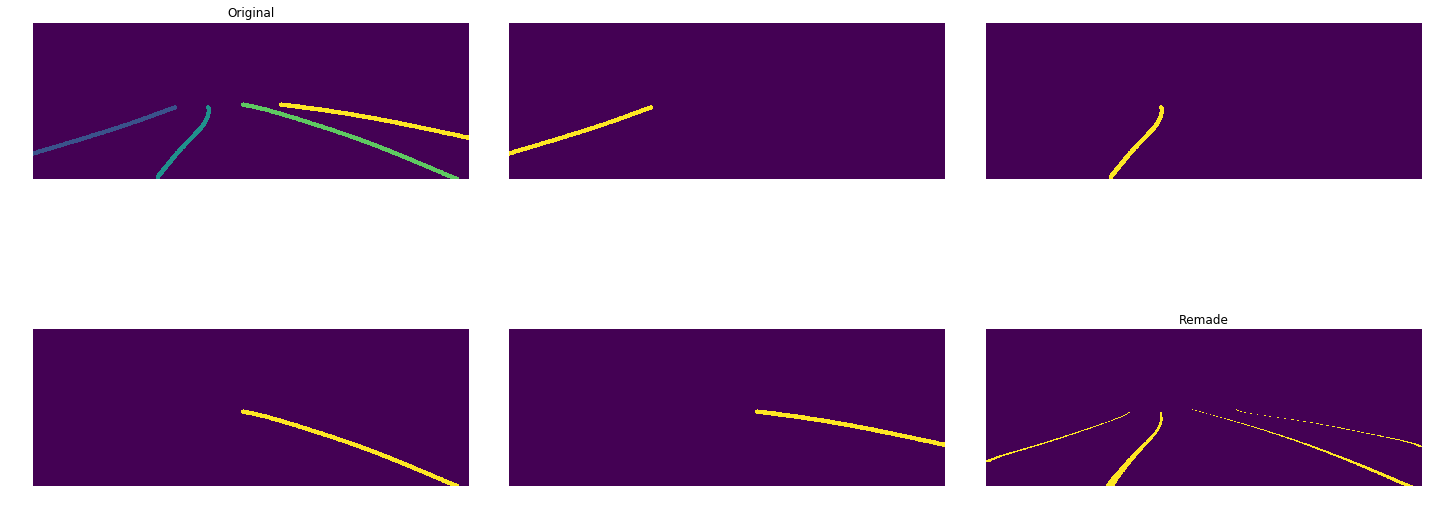

In [17]:
plt.rcParams["figure.figsize"] = (20,10)
ORDER = 6
POLY_COLOR = (255, 255, 255)
POLY_THICKNESS = 20
Y_POLY_POINT_STEP = 1

r_ind = 43456  # A random curvy section

for i, annotation_path in enumerate(annotation_paths):
    print("Processing image ", CMD_C.OKGREEN, i, CMD_C.ENDC, " / ", len(annotation_paths), " : ", sep="", end="")
    save_to_path = annotation_path[len(data_base_dir):]  # Save to CWD's same path as in the database dir
    #print(save_to_path)
    # Change save_to_path base dir to include the dest_folder_extension
    tok = save_to_path.split("/")
    #print(tok)
    save_to_path = tok[0] + dest_folder_extension + save_to_path[len(tok[0]):]
    #print(save_to_path)
    #IPython.embed() # to debug in notebook

    # Read image
    img = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    print("read ", sep="", end="")
    remade_img = np.zeros(img.shape, img.dtype)  # Should be 1640x590, uint8
    
    # Separate by label (either 1, 2, 3, or 4)
    img_1 = img == 1
    img_2 = img == 2
    img_3 = img == 3
    img_4 = img == 4
    
    # Points in form (y,x)
    img_1_points = np.argwhere(img_1 != 0)
    img_2_points = np.argwhere(img_2 != 0)
    img_3_points = np.argwhere(img_3 != 0)
    img_4_points = np.argwhere(img_4 != 0)
    
    # Polynomial regression, Evaluate polynomial, Draw polynomial
    if img_1_points.shape[0] > 0:
        img_1_coeef = np.polyfit(img_1_points[:,0], img_1_points[:,1], ORDER)  # As a function of Y
        y_vals = list(range(min(img_1_points[:,0]), max(img_1_points[:,0]), Y_POLY_POINT_STEP))
        img_1_x_vals = [np.polyval(img_1_coeef, y) for y in y_vals]
        img_1_poly_points = np.column_stack((img_1_x_vals, y_vals))
        img_1_poly_points = np.int32(img_1_poly_points)
        draw_lane(remade_img, img_1_poly_points, POLY_COLOR)
        
    if img_2_points.shape[0] > 0:
        img_2_coeef = np.polyfit(img_2_points[:,0], img_2_points[:,1], ORDER)
        y_vals = list(range(min(img_2_points[:,0]), max(img_2_points[:,0]), Y_POLY_POINT_STEP))
        img_2_x_vals = [np.polyval(img_2_coeef, y) for y in y_vals]
        img_2_poly_points = np.column_stack((img_2_x_vals, y_vals))
        img_2_poly_points = np.int32(img_2_poly_points)
        draw_lane(remade_img, img_2_poly_points, POLY_COLOR)
        
    if img_3_points.shape[0] > 0:
        img_3_coeef = np.polyfit(img_3_points[:,0], img_3_points[:,1], ORDER)
        y_vals = list(range(min(img_3_points[:,0]), max(img_3_points[:,0]), Y_POLY_POINT_STEP))
        img_3_x_vals = [np.polyval(img_3_coeef, y) for y in y_vals]
        img_3_poly_points = np.column_stack((img_3_x_vals, y_vals))
        img_3_poly_points = np.int32(img_3_poly_points)
        draw_lane(remade_img, img_3_poly_points, POLY_COLOR)
        
    if img_4_points.shape[0] > 0:
        img_4_coeef = np.polyfit(img_4_points[:,0], img_4_points[:,1], ORDER)
        y_vals = list(range(min(img_4_points[:,0]), max(img_4_points[:,0]), Y_POLY_POINT_STEP))
        img_4_x_vals = [np.polyval(img_4_coeef, y) for y in y_vals]
        img_4_poly_points = np.column_stack((img_4_x_vals, y_vals))
        img_4_poly_points = np.int32(img_4_poly_points)
        draw_lane(remade_img, img_4_poly_points, POLY_COLOR)
    
    print("processed ", sep="", end="")
    
    # Save new image (as PNG)
    save_success = cv2.imwrite(save_to_path, remade_img)
    if save_success:
        print("saved to ", save_to_path, sep="")
    else:
        print(CMD_C.FAIL, "FAILED TO SAVE IMAGE", CMD_C.ENDC, save_to_path, annotation_path)
    
    # Show result for first frame if display results
    if display_results == True:
        f, axs = plt.subplots(2, 3)
        for _, ax in np.ndenumerate(axs):   # Remove axes
            ax.axis('off')
        axs[0][0].imshow(img)
        axs[0][1].imshow(img_1)
        axs[0][2].imshow(img_2)
        axs[1][0].imshow(img_3)
        axs[1][1].imshow(img_4)
        axs[1][2].imshow(remade_img)
        axs[0][0].set_title("Original")
        axs[1][2].set_title("Remade")
        plt.tight_layout()
        plt.show()
        break

In [14]:
print("All done!")

All done!


In [ ]:
# Still need to wrtie the polynomials as numbers 1,2,3,4, not just white pixels